# Stress profile evaluation

In [1]:
%matplotlib widget
import ibvpy.api as ib
import matplotlib.pylab as plt
from matplotlib import cm
from bmcs_shear.dic_crack import\
    DICGrid, DICInpUnstructuredPoints, DICStateFields, \
    DICAlignedGrid, DICGrid
from bmcs_shear.dic_crack.dic_crack_list2 import DICCrackList
import numpy as np
np.seterr(divide ='ignore', invalid='ignore');

In [2]:
dic_points = DICInpUnstructuredPoints(U_factor=10, dir_name='B9_TV2', t=1,
                                      n_T_max=40, T_stepping='delta_T')
dic_points.read_beam_design()
dic_grid = DICGrid(dic_inp=dic_points, d_x=5, d_y=5)

In [3]:
dsf = DICStateFields(dic_grid=dic_grid, R=6, omega_threshold=0.15, verbose_eval=True)
dsf.tmodel_.trait_set(E=1400, c_T=0.006, nu=0.18, epsilon_0=0.0018,
                      epsilon_f=0.0019, eps_max=0.01);
dsf = DICStateFields(dic_grid=dic_grid, R=5, omega_threshold=0.15, verbose_eval=True, tmodel='scalar_damage')
dsf.tmodel_.trait_set(E=1600, nu=0.18, omega_fn='exp-slope', strain_norm='Rankine', eps_max=0.01)
dsf.tmodel_.omega_fn_.trait_set(kappa_0=0.002, kappa_f=0.0028);
dcl = DICCrackList(dsf=dsf, delta_alpha_min=-np.pi/6, delta_alpha_max=np.pi/3, delta_s = 25, x_boundary=30)

In [4]:
dcl.interact()

In [5]:
c = 5
sp = dcl.cracks[str(c)].sp

In [6]:
sp.interact()

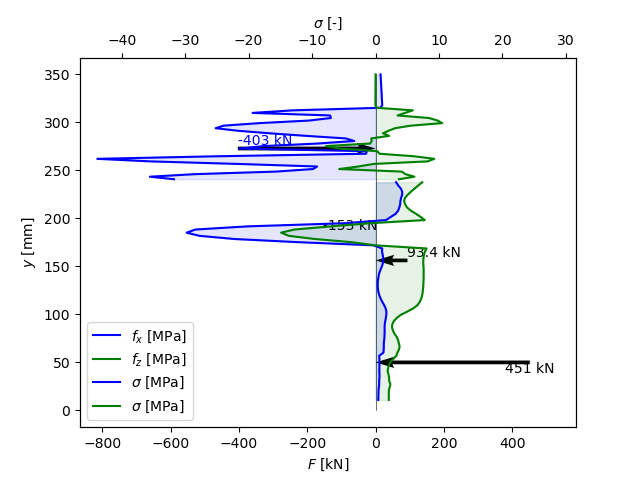

In [7]:
import bmcs_utils.api as bu
%matplotlib widget
fig, ax_F = plt.subplots(1,1)
ax_sig = ax_F.twiny()
sp.plot_sig_t_crc_La(ax_sig)
sp.plot_sig_t_unc_Lab(ax_sig)
sp.plot_F_t_a(ax_F)
bu.mpl_align_xaxis(ax_sig, ax_F)

# Check to see if the global moment equilibrium is related to the correct point

In [8]:
dcl.cracks

{'0': <bmcs_shear.dic_crack.dic_crack2.DICCrack at 0x18f326b6770>,
 '1': <bmcs_shear.dic_crack.dic_crack2.DICCrack at 0x18f33bcdc20>,
 '2': <bmcs_shear.dic_crack.dic_crack2.DICCrack at 0x18f33bcdb80>,
 '3': <bmcs_shear.dic_crack.dic_crack2.DICCrack at 0x18f328dbe50>,
 '4': <bmcs_shear.dic_crack.dic_crack2.DICCrack at 0x18f33c03220>,
 '5': <bmcs_shear.dic_crack.dic_crack2.DICCrack at 0x18f33c38cc0>,
 '6': <bmcs_shear.dic_crack.dic_crack2.DICCrack at 0x18f33c767c0>,
 '7': <bmcs_shear.dic_crack.dic_crack2.DICCrack at 0x18f33cb32c0>}

crack 0
crack 1
crack 2
crack 3
crack 4
crack 5
crack 6
crack 7


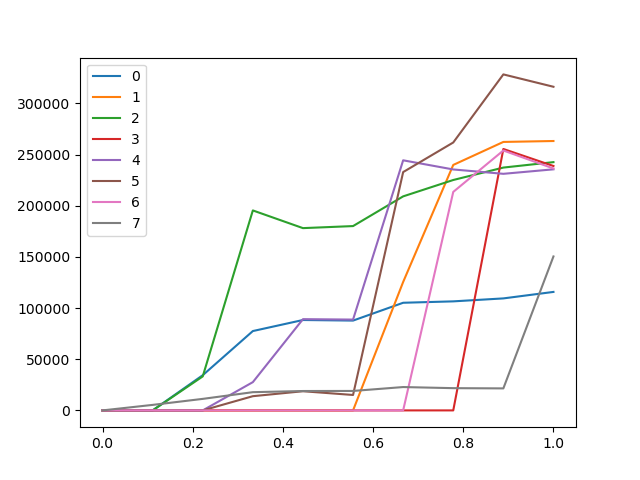

In [9]:
%matplotlib widget
fig, ax = plt.subplots(1,1)
for c, crack in dcl.cracks.items():
    print('crack', c)
    sp = crack.sp
    V_crc_t_ = []
    V_unc_t_ = []
    t_range = np.linspace(0,1,10)
    for t in t_range:
        dcl.dsf.dic_grid.t = t
        V_crc_t_.append(sp.V_crc_y)
        V_unc_t_.append(sp.V_unc_y)
    V_crc_t = np.array(V_crc_t_)
    V_unc_t = np.array(V_unc_t_)
    ax.plot(t_range, V_crc_t[:,0], label=c)
#    ax.plot(t_range, V_unc_t[:,0])
ax.legend()